https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-95x

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [22]:
all_files = ['./data/sub_feat457_modelselect.csv',
             './data/sub_feat476_rm_pm0.csv',
            './data/sub_feat476_rmv91.csv',
            './data/sub_xgb_feat457_lr01.csv']

In [23]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
all_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "sub" + str(x), range(len(all_sub.columns))))
all_sub.columns = cols
all_sub.reset_index(inplace=True)

In [24]:
all_sub.head()

,TransactionID,sub0,sub1,sub2,sub3
0,3663549,0.001578,0.001301,0.001143,0.001358
1,3663550,0.000631,0.000615,0.000615,0.000611
2,3663551,0.001217,0.000861,0.000959,0.001757
3,3663552,0.001046,0.001046,0.001142,0.001037
4,3663553,0.000626,0.000428,0.000441,0.000224


In [25]:
# calculate correlation of submissions
corr = all_sub.iloc[:,1:].corr()

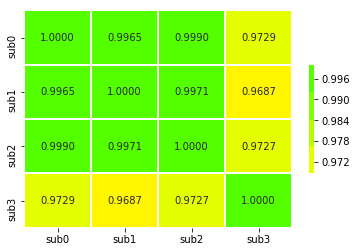

In [26]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [27]:
corr_rank = np.tril(all_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(corr.shape),1)
corr_rank

array([[1.        , 1.        , 1.        , 1.        ],
       [0.99651101, 1.        , 1.        , 1.        ],
       [0.99902149, 0.99709148, 1.        , 1.        ],
       [0.9728779 , 0.96866412, 0.97270256, 1.        ]])

In [28]:
# calculate how many times of blend is needed
blend_times = (corr_rank>0).sum() - (corr_rank>0.99).sum()
blend_times

3

In [29]:
m_gmean, weight_sum = 0, 0

In [30]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean
for i in range(blend_times):
    min_corr_indexs = np.unravel_index(corr_rank.argmin(), corr_rank.shape)
    print('%s round with current minimual index%s'%(i,min_corr_indexs))
    # weight decay with higher correlations
    weight = (blend_times-i)/blend_times
    m_gmean += weight*(np.log(all_sub.iloc[:,min_corr_indexs[0]+1])+np.log(all_sub.iloc[:,min_corr_indexs[1]+1]))/2
    print(m_gmean.head())
    weight_sum += weight
    print('current weight:%s, total weight:%s'%(weight,weight_sum))
    corr_rank[min_corr_indexs] = 1
    print(corr_rank)

0 round with current minimual index(3, 1)
0   -6.623176
1   -7.396805
2   -6.700450
3   -6.866717
4   -8.080707
dtype: float64
current weight:1.0, total weight:1.0
[[1.         1.         1.         1.        ]
 [0.99651101 1.         1.         1.        ]
 [0.99902149 0.99709148 1.         1.        ]
 [0.9728779  1.         0.97270256 1.        ]]
1 round with current minimual index(3, 2)
0   -11.081779
1   -12.327739
2   -11.131806
3   -11.415351
4   -13.457789
dtype: float64
current weight:0.6666666666666666, total weight:1.6666666666666665
[[1.         1.         1.         1.        ]
 [0.99651101 1.         1.         1.        ]
 [0.99902149 0.99709148 1.         1.        ]
 [0.9728779  1.         1.         1.        ]]
2 round with current minimual index(3, 0)
0   -13.257310
1   -14.788929
2   -13.307702
3   -13.704267
4   -16.087930
dtype: float64
current weight:0.3333333333333333, total weight:1.9999999999999998
[[1.         1.         1.         1.        ]
 [0.99651101 

In [31]:
m_gmean = np.exp(m_gmean/weight_sum)
m_gmean.head()

0    0.001322
1    0.000615
2    0.001289
3    0.001057
4    0.000321
dtype: float64

In [32]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.001297
1    0.000589
2    0.001264
3    0.001032
4    0.000295
dtype: float64

In [33]:
all_sub['isFraud'] = m_gmean
all_sub.tail()

,TransactionID,sub0,sub1,sub2,sub3,isFraud
506686,4170235,0.005848,0.004531,0.004480,0.001157,0.002311
506687,4170236,0.002687,0.003591,0.002441,0.000242,0.000828
506688,4170237,0.002786,0.002540,0.002777,0.000236,0.000766
506689,4170238,0.002308,0.001858,0.002219,0.000576,0.001059
506690,4170239,0.003451,0.003617,0.004219,0.000766,0.001676


In [34]:
all_sub[['TransactionID','isFraud']].to_csv('./data/sub_4stack_gmean.csv',index=False)